In [19]:
import os
import librosa
import re
import numpy as np
import librosa
import librosa.display
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


In [20]:
def apply_windowing(audio, window_size, hop_size, window_type="hann"):
    """
    Apply windowing to an audio signal.

    Parameters:
    - audio: 1D numpy array, the input audio signal
    - window_size: int, the size of each window in samples
    - hop_size: int, the number of samples to skip between windows (overlap = window_size - hop_size)
    - window_type: str, type of window function ("hann", "hamming", "rectangular", etc.)

    Returns:
    - windows: 2D numpy array where each row is a windowed segment
    """
    # Number of frames
    num_windows = (len(audio) - window_size) // hop_size + 1

    # Select the desired window function
    if window_type == "hann":
        window = np.hanning(window_size)
    elif window_type == "hamming":
        window = np.hamming(window_size)
    elif window_type == "rectangular":
        window = np.ones(window_size)
    else:
        raise ValueError("Unsupported window type. Choose 'hann', 'hamming', or 'rectangular'.")

    # Create windows
    windows = np.array([
        audio[i * hop_size : i * hop_size + window_size] * window
        for i in range(num_windows)
    ])

    return windows

In [21]:
def preprocessing(audio):
    y = extract_middle_audio_with_padding(audio,1000000)
    y_filtered = denoising_spectral_subtraction(y)
    signal, sample_rate = y_filtered, 48000
    # print((signal.shape[0]-1024)/512)
    # RMS normalization
    rms = np.sqrt(np.mean(signal**2))
    signal_normalized = signal / (rms + 1e-8)
    return signal_normalized



In [22]:
def extract_middle_audio_with_padding(audio, target_length):
    """
    Extract the middle portion of a 1D audio signal and pad if necessary.
    Args:
        audio (np.ndarray): 1D array representing the audio signal.
        target_length (int): Desired length of the extracted middle portion.
    Returns:
        np.ndarray: Middle portion of the audio signal (padded if necessary).
    """
    audio_length = len(audio)

    if audio_length < target_length:
        # Calculate padding on both sides
        pad_width = (target_length - audio_length) // 2
        remainder = (target_length - audio_length) % 2

        # Pad symmetrically (add remainder to the end if necessary)
        padded_audio = np.pad(
            audio,
            pad_width=(pad_width, pad_width + remainder),
            mode='constant',
            constant_values=0
        )
        return padded_audio
    else:
        # Extract middle portion
        start_idx = (audio_length - target_length) // 2
        end_idx = start_idx + target_length
        middle_audio = audio[start_idx:end_idx]
        return middle_audio

In [23]:
def denoising_spectral_subtraction(y):
  y = extract_middle_audio_with_padding(y,1000000)

  # Compute the spectrogram (STFT)
  S_full = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
  phase = np.angle(librosa.stft(y, n_fft=2048, hop_length=512))

  # Estimate the noise spectrum (minimum energy across time)
  noise_est = np.min(S_full, axis=1, keepdims=True)

  # Perform spectral subtraction
  S_clean = np.maximum(S_full - noise_est, 0)

  # Reconstruct the signal using the original phase
  noise_complex = noise_est * np.exp(1j * phase)
  noise = librosa.istft(noise_complex, hop_length=512)

  S_clean_complex = S_clean * np.exp(1j * phase)
  y_clean = librosa.istft(S_clean_complex, hop_length=512)
  # Define the bandpass filter
  def bandpass_filter(data, sr, lowcut, highcut, order=5):
      nyquist = 0.5 * sr
      low = lowcut / nyquist
      high = highcut / nyquist
      b, a = butter(order, [low, high], btype='band')
      y_filtered = filtfilt(b, a, data)
      return y_filtered

  y = y_clean
  # Define the bandpass filter parameters
  lowcut = 300.0  # Lower bound of the frequency (Hz)
  highcut = 3000.0  # Upper bound of the frequency (Hz)

  # Apply the bandpass filter
  y_filtered = bandpass_filter(y, sr, lowcut, highcut)
  return y_filtered

In [24]:
def feature_extraction(signal_normalized, sample_rate = 48000):
  # Extract MFCCs with Hann windowing
  mfccs = librosa.feature.mfcc(
      y=signal_normalized,
      sr=sample_rate,
      n_mfcc=13,
      n_fft=1024,
      hop_length=512,
      window='hann'
  )
  # print(mfccs.shape)

  # Mean normalization (optional)
  mfccs_mean_normalized = mfccs - np.mean(mfccs)

  
  
  spectral_bandwidth = librosa.feature.spectral_bandwidth(
      y=signal_normalized,
      sr=sample_rate,
      n_fft=1024,
      hop_length=512,
      window='hann'
  )
  # print(spectral_bandwidth.shape)

  MEL = librosa.feature.melspectrogram(
    y=signal_normalized,
    sr=sample_rate,
    n_fft=1024,
    n_mels=128,
    fmax= sample_rate//2,
    hop_length=512,
    window='hann'
  )
  # /print(MEL.shape)

  
  Spectral_Centroid = librosa.feature.spectral_centroid(
      S=MEL,
      sr=sample_rate,
      n_fft=1024,
      hop_length=512,
      window='hann'
  )
  # print(Spectral_Centroid.shape)

  Spectral_Contrast= librosa.feature.spectral_contrast(
    y=signal_normalized,
    sr=sample_rate,
    n_fft=1024,
    hop_length=512,
    window='hann'
  )
  # print(Spectral_Contrast.shape)

  Zcr= librosa.feature.zero_crossing_rate(
    y=signal_normalized,
    frame_length= 2048,
    hop_length=512
  )
  # print(Zcr.shape)


  Feature_Matrix = np.concatenate((mfccs_mean_normalized, spectral_bandwidth,MEL,Spectral_Centroid,Spectral_Contrast, Zcr)).T
  print(Feature_Matrix.shape)

  return Feature_Matrix


In [25]:
def feature_extraction_plus(filtered_signal):
  
  S_mel = librosa.feature.melspectrogram(y=y_filtered, sr=sr, n_mels=128, fmax=sr // 2)

  # Step 3: Convert Mel spectrogram to dB for visualization
  S_mel_db = librosa.power_to_db(S_mel, ref=np.max)
  # Extract MFCCs with Hann windowing
  SC = librosa.feature.spectral_centroid(
      S=S_mel,
      sr=sample_rate,
      n_fft=1024,
      hop_length=512,
      window='hann'
  )
  print(SC)

  # Step 5: Time array for the spectral centroids
  frames = range(SC.shape[1])
  t = librosa.frames_to_time(frames, sr=sr)

  # Step 6: Convert spectral centroids to Mel scale for overlay
  mel_frequencies = librosa.mel_frequencies(n_mels=128, fmin=0, fmax=sr // 2)
  centroid_mel = np.interp(SC[0], np.linspace(0, sr // 2, len(mel_frequencies)), mel_frequencies)


  S_mel = librosa.feature.melspectrogram(y=y_filtered, sr=sr, n_mels=128, fmax=sr // 2)

  # Step 3: Convert the Mel spectrogram to dB scale for visualization
  S_mel_db = librosa.power_to_db(S_mel, ref=np.max)
  spectral_centroids = SC
  # Step 4: Compute spectral centroid and spectral bandwidth
  spectral_bandwidth = librosa.feature.spectral_bandwidth(
      y=y_filtered,
      sr=sample_rate,
      n_fft=1024,
      hop_length=512,
      window='hann'
  )
  # Step 5: Time array for centroids and bandwidth
  frames = range(spectral_centroids.shape[1])
  t = librosa.frames_to_time(frames, sr=sr)

  # Step 6: Convert centroids and bandwidth to Mel scale
  mel_frequencies = librosa.mel_frequencies(n_mels=128, fmin=0, fmax=sr // 2)
  centroids_mel = np.interp(spectral_centroids[0], np.linspace(0, sr // 2, len(mel_frequencies)), mel_frequencies)
  bandwidth_mel = np.interp(spectral_bandwidth[0], np.linspace(0, sr // 2, len(mel_frequencies)), mel_frequencies)

  # Calculate the interval (centroid ± bandwidth)
  upper_bound = centroids_mel + bandwidth_mel
  lower_bound = centroids_mel - bandwidth_mel

  mel = librosa.feature.melspectrogram(
    y=signal_normalized,
    sr=sample_rate,
    n_fft=1024,
    n_mels=128,
    fmax= sample_rate//2,
    hop_length=512,
    window='hann'
  )
  log_mel_spectrogram = librosa.power_to_db(mel)

  Scon= librosa.feature.spectral_contrast(
    y=signal_normalized,
    sr=sample_rate,
    n_fft=1024,
    hop_length=512,
    window='hann'
  )

  Zcr= librosa.feature.zero_crossing_rate(
    y=signal_normalized,
    frame_length= 2048,
    hop_length=512
  )




In [ ]:
audio_folder="./HW1_M"
files = os.listdir(audio_folder)

audio_files = [file for file in files if file.endswith(('.mp3', '.wav', '.flac', '.ogg'))]

print("Audio files:", len(audio_files))

for audio_file in audio_files[:1]:

    file_path = os.path.join(audio_folder, audio_file)

    # print(f"Loading {audio_file}...")
    y, sr = librosa.load(file_path, sr=48000)
    matches = list(label_pattern.finditer(audio_file))

    if matches:
        match = matches[0]

        gender = match.group(2).lower()
        student_id = match.group(1)
        gender = np.array(gender)
        student_id = np.array(student_id)

        preprocessed = preprocessing(y)
        audio_features = feature_extraction(preprocessed)

        gender_rep  = np.repeat(gender, repeats=1954, axis= 0).reshape(-1, 1)
        student_id_rep  = np.repeat(student_id, repeats=1954, axis= 0).reshape(-1,1)

        Feature_Matrix = np.concatenate((audio_features, gender_rep, student_id_rep), axis= 1)



In [ ]:
def feature_extraction_Show(signal_normalized, sample_rate = 48000):
  # Extract MFCCs with Hann windowing
  mfccs = librosa.feature.mfcc(
      y=signal_normalized,
      sr=sample_rate,
      n_mfcc=13,
      n_fft=1024,
      hop_length=512,
      window='hann'
  )
  print(mfccs.shape)

  # Mean normalization (optional)
  mfccs_mean_normalized = mfccs - np.mean(mfccs)

  
  
  spectral_bandwidth = librosa.feature.spectral_bandwidth(
      y=signal_normalized,
      sr=sample_rate,
      n_fft=1024,
      hop_length=512,
      window='hann'
  )
  print(spectral_bandwidth.shape)

  MEL = librosa.feature.melspectrogram(
    y=signal_normalized,
    sr=sample_rate,
    n_fft=1024,
    n_mels=128,
    fmax= sample_rate//2,
    hop_length=512,
    window='hann'
  )
  print(MEL.shape)

  
  spectral_centroids = librosa.feature.spectral_centroid(
      S=MEL,
      sr=sample_rate,
      n_fft=1024,
      hop_length=512,
      window='hann'
  )
  print(spectral_centroids.shape)


  # Step 5: Time array for centroids and bandwidth
  frames = range(spectral_centroids.shape[1])
  t = librosa.frames_to_time(frames, sr=sr)

  # Step 6: Convert centroids and bandwidth to Mel scale
  mel_frequencies = librosa.mel_frequencies(n_mels=128, fmin=0, fmax=sr // 2)
  centroids_mel = np.interp(spectral_centroids[0], np.linspace(0, sr // 2, len(mel_frequencies)), mel_frequencies)
  bandwidth_mel = np.interp(spectral_bandwidth[0], np.linspace(0, sr // 2, len(mel_frequencies)), mel_frequencies)

  # Calculate the interval (centroid ± bandwidth)
  upper_bound = centroids_mel + bandwidth_mel
  lower_bound = centroids_mel - bandwidth_mel

  # Step 7: Plot the Mel spectrogram with spectral centroid and bandwidth interval
  plt.figure(figsize=(25, 6))
  librosa.display.specshow(S_mel_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
  plt.plot(t, centroids_mel, color='cyan', linewidth=2, label='Spectral Centroid')
  plt.fill_between(t, lower_bound, upper_bound, color='white', alpha=0.7, label='Bandwidth Interval')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Spectral Bandwidth as Interval on Mel Spectrogram')
  plt.xlabel('Time (s)')
  plt.ylabel('Frequency (Mel)')
  plt.legend(loc='upper right')
  plt.show()

  Spectral_Contrast= librosa.feature.spectral_contrast(
    y=signal_normalized,
    sr=sample_rate,
    n_fft=1024,
    hop_length=512,
    window='hann'
  )
  print(Spectral_Contrast.shape)

  # plt.figure(figsize=(10, 6))
  # librosa.display.specshow(Scon, x_axis='time', sr=sr)
  # plt.title('Spectral Contrast')
  # plt.colorbar()
  # plt.show()

  Zcr= librosa.feature.zero_crossing_rate(
    y=signal_normalized,
    frame_length= 2048,
    hop_length=512
  )
  print(Zcr.shape)

  plt.figure(figsize=(25,6))
  plt.plot(range(Zcr.shape[1]),Zcr[0,:])
  plt.xlabel("Frame Index")
  plt.ylabel('ZCR')
  plt.show()

  Feature_Matrix = np.concatenate((mfccs_mean_normalized, spectral_bandwidth,MEL,Spectral_Centroid,Spectral_Contrast, Zcr)).T
  print(Feature_Matrix.shape)

  return Feature_Matrix


In [26]:
audio_folder="./HW1_M"
files = os.listdir(audio_folder)

audio_files = [file for file in files if file.endswith(('.mp3', '.wav', '.flac', '.ogg'))]

print("Audio files:", len(audio_files))

Audio files: 822


In [27]:
label_pattern = re.compile(r".+([0-9]{9}).(male|female|MALE|FEMALE|Male|Female).+")

filename = "matrix1.csv"
i = 0 

for audio_file in audio_files[:]:

    file_path = os.path.join(audio_folder, audio_file)

    # print(f"Loading {audio_file}...")
    y, sr = librosa.load(file_path, sr=48000)
    matches = list(label_pattern.finditer(audio_file))

    if matches:
        match = matches[0]

        gender = match.group(2).lower()
        student_id = match.group(1)
        gender = np.array(gender)
        student_id = np.array(student_id)

        preprocessed = preprocessing(y)
        audio_features = feature_extraction(preprocessed)

        gender_rep  = np.repeat(gender, repeats=1954, axis= 0).reshape(-1, 1)
        student_id_rep  = np.repeat(student_id, repeats=1954, axis= 0).reshape(-1,1)

        Feature_Matrix = np.concatenate((audio_features, gender_rep, student_id_rep), axis= 1)



        # Check if the file exists
        if os.path.exists(filename):
            # Load existing data
            # existing_data = pd.read_csv(filename, header=None)
            
            # Convert new_row to DataFrame and append
            new_data = pd.DataFrame(Feature_Matrix)
            new_data = new_data.round(8)
            existing_data = pd.concat([existing_data, new_data], ignore_index=True)
            
            # Save back to CSV
            # updated_data.to_csv(filename, index=False, header=False)
        else:
            # Save new data if file doesn't exist
            pd.DataFrame(Feature_Matrix).to_csv(filename, index=False, header=False)
            existing_data = pd.read_csv(filename, header=None)

        print(f"Row added to {i} successfully!")
        i+= 1

existing_data.to_csv(filename, index=False, header=False)        
print("Loaded all audio files!")



(1954, 151)
Row added to 0 successfully!
(1954, 151)
Row added to 1 successfully!
(1954, 151)
Row added to 2 successfully!
(1954, 151)
Row added to 3 successfully!
(1954, 151)
Row added to 4 successfully!
(1954, 151)
Row added to 5 successfully!
(1954, 151)
Row added to 6 successfully!
(1954, 151)
Row added to 7 successfully!
(1954, 151)
Row added to 8 successfully!
(1954, 151)
Row added to 9 successfully!
(1954, 151)
Row added to 10 successfully!
(1954, 151)
Row added to 11 successfully!
(1954, 151)
Row added to 12 successfully!
(1954, 151)
Row added to 13 successfully!
(1954, 151)
Row added to 14 successfully!
(1954, 151)
Row added to 15 successfully!
(1954, 151)
Row added to 16 successfully!
(1954, 151)
Row added to 17 successfully!
(1954, 151)
Row added to 18 successfully!
(1954, 151)
Row added to 19 successfully!
(1954, 151)
Row added to 20 successfully!
(1954, 151)
Row added to 21 successfully!
(1954, 151)
Row added to 22 successfully!
(1954, 151)
Row added to 23 successfully!
(1

KeyboardInterrupt: 

In [28]:
existing_data.shape

(992632, 153)

In [29]:
existing_data.to_csv(filename, index=False, header=False)        
print("Loaded all audio files!")


Loaded all audio files!


In [98]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# # Assuming `features` is a matrix of shape (n_samples, n_features)
# tsne = TSNE(n_components=2, random_state=42)
# reduced_features = tsne.fit_transform(np.asarray(valid_audios))

# gender_colors = {'male': 'blue', 'female': 'red'}
# colors = [gender_colors[gender] for gender in genders]

# # Plot the reduced features
# plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c= colors)
# plt.title("t-SNE Visualization of Features")
# plt.legend()
# plt.show()

# MFCC

#  SC

In [ ]:
# S_mel = librosa.feature.melspectrogram(y=y_filtered, sr=sr, n_mels=128, fmax=sr // 2)

# # Step 3: Convert the Mel spectrogram to dB scale for visualization
# S_mel_db = librosa.power_to_db(S_mel, ref=np.max)
# spectral_centroids = SC
# # Step 4: Compute spectral centroid and spectral bandwidth
# spectral_bandwidth = librosa.feature.spectral_bandwidth(
#     y=y_filtered,
#     sr=sr,
#     n_fft=1024,
#     hop_length=512,
#     window='hann'
# )
# print(spectral_bandwidth.shape)
# # Step 5: Time array for centroids and bandwidth
# frames = range(spectral_centroids.shape[1])
# t = librosa.frames_to_time(frames, sr=sr)

# # Step 6: Convert centroids and bandwidth to Mel scale
# mel_frequencies = librosa.mel_frequencies(n_mels=128, fmin=0, fmax=sr // 2)
# centroids_mel = np.interp(spectral_centroids[0], np.linspace(0, sr // 2, len(mel_frequencies)), mel_frequencies)
# bandwidth_mel = np.interp(spectral_bandwidth[0], np.linspace(0, sr // 2, len(mel_frequencies)), mel_frequencies)

# # Calculate the interval (centroid ± bandwidth)
# upper_bound = centroids_mel + bandwidth_mel
# lower_bound = centroids_mel - bandwidth_mel

# # Step 7: Plot the Mel spectrogram with spectral centroid and bandwidth interval
# plt.figure(figsize=(25, 6))
# librosa.display.specshow(S_mel_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
# plt.plot(t, centroids_mel, color='cyan', linewidth=2, label='Spectral Centroid')
# plt.fill_between(t, lower_bound, upper_bound, color='white', alpha=0.7, label='Bandwidth Interval')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Spectral Bandwidth as Interval on Mel Spectrogram')
# plt.xlabel('Time (s)')
# plt.ylabel('Frequency (Mel)')
# plt.legend(loc='upper right')
# plt.show()

In [100]:
#   # Convert to decibel scale (log)
# print("Log Mel Spectrogram Shape:", log_mel_spectrogram.shape)

In [101]:
# # Plot Log Mel Spectrogram
# plt.figure(figsize=(10, 6))
# librosa.display.specshow(log_mel_spectrogram, x_axis='time', sr=sr)
# plt.title('Log Mel Spectrogram')
# plt.colorbar()
# plt.show()

In [102]:
# # Extract MFCCs with Hann windowing
# Scon= librosa.feature.spectral_contrast(
#     y=signal_normalized,
#     sr=sample_rate,
#     n_fft=1024,
#     hop_length=512,
#     window='hann'
# )
# print(Scon.shape)

In [103]:
# # Plot Spectral Contrast
# plt.figure(figsize=(10, 6))
# librosa.display.specshow(Scon, x_axis='time', sr=sr)
# plt.title('Spectral Contrast')
# plt.colorbar()
# plt.show()


In [ ]:
# Zcr= librosa.feature.zero_crossing_rate(
#     y=y_clean,
#     frame_length= 2048,
#     hop_length=512
# )
# print(Zcr.shape)

# plt.figure(figsize=(25,6))
# plt.plot(range(Zcr.shape[1]),Zcr[0,:])
# plt.xlabel("Frame Index")
# plt.ylabel('ZCR')
# plt.show()

In [31]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 393.8 kB/s eta 0:05:18
   ---------------------------------------- 0.1/124.9 MB 491.5 kB/s eta 0:04:14
   ---------------------------------------- 0.1/124.9 MB 778.5 kB/s eta 0:02:41
   ---------------------------------------- 0.1/124.9 MB 778.5 kB/s eta 0:02:41
   ---------------------------------------- 0.2/124.9 MB 901.1 kB/s eta 0:02:19
   ---------------------------------------- 0.3/124.9 MB 1.1 MB/s eta 0:01:53
   ---------------------------------------- 0.5/124.9 MB 1.3 MB/s eta 0:01:33
   ---------------------------------------- 0.5/124.9 MB 1.3 MB/s eta 0:01:37
   ---------------------------------------- 0.6/124.9 MB 1.4 MB/s eta 0:01:27
   ---------------------------------------- 0.7/124.9 MB 1.5 MB/s eta 0:01:24
   ---------------------------------------- 0.8/124.9 MB 1.5 MB/s et


[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import random 
from sklearn.metrics import mean_squared_error as MSE 
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.utils.fixes import parse_version
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc


In [4]:
from sklearn.metrics import roc_curve, auc

def ROC_curve(y_test, y_pred, n_classes = 2):

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend()
    plt.show()



In [12]:
from itertools import cycle
from sklearn.preprocessing import label_binarize

def ROC_curve_multi(y_test, y_pred, n_classes):
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green"])

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1])

In [5]:
df = pd.read_csv('matrix1.csv')


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize, MinMaxScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import type_of_target

# Define the multi-class ROC function
def ROC_curve_multi(y_test, y_pred_proba, n_classes):
    """
    Plots ROC curves for multi-class classification.

    Parameters:
    - y_test: True labels (one-hot encoded).
    - y_pred_proba: Predicted probabilities for each class.
    - n_classes: Number of classes.
    """
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    print(y_test_bin.shape)
    fpr, tpr, roc_auc = {}, {}, {}

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green", "purple", "orange", "brown"])

    for i, color in zip(range(n_classes), colors):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Main loop for sampling and evaluating models



Explained variance by each component: [3.86067394e-01 1.33704335e-01 8.87330105e-02 5.32578921e-02
 4.78425036e-02 4.08171616e-02 2.98190239e-02 2.92506484e-02
 2.62671099e-02 2.10860515e-02 1.81677849e-02 1.52445374e-02
 1.29419321e-02 1.10844172e-02 9.76246152e-03 9.06408593e-03
 7.41343179e-03 6.57009740e-03 5.83015582e-03 4.49529075e-03
 3.90458982e-03 3.28181200e-03 3.18119514e-03 3.01161638e-03
 2.64901417e-03 1.94168211e-03 1.90022937e-03 1.83313208e-03
 1.67423884e-03 1.55237846e-03 1.53813553e-03 1.30084117e-03
 1.28388123e-03 1.08485560e-03 1.02575583e-03 8.02239586e-04
 7.40958741e-04 6.99558432e-04 6.36015238e-04 5.59669870e-04
 5.37574691e-04 5.29935803e-04 5.02643824e-04 4.72406127e-04
 4.50485456e-04 4.11529782e-04 3.66841379e-04 3.45998199e-04
 2.92834513e-04 2.73158043e-04 2.63190232e-04 2.56932691e-04
 2.36842658e-04 2.18317856e-04 2.14739096e-04 2.08170994e-04
 1.84526701e-04 1.74033073e-04 1.69876281e-04 1.57455219e-04
 1.49533605e-04 1.34178601e-04 1.20391690e-04 1

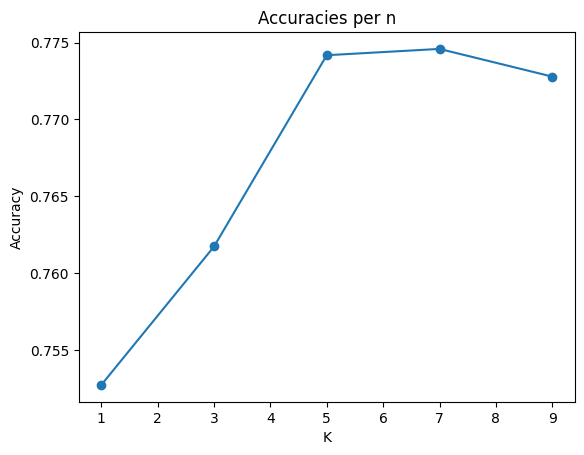

[[0.         0.         0.28571429 0.         0.71428571 0.        ]
 [0.         0.         0.57142857 0.28571429 0.         0.14285714]
 [0.28571429 0.14285714 0.14285714 0.14285714 0.         0.28571429]
 ...
 [0.         0.         0.         0.         1.         0.        ]
 [0.42857143 0.         0.         0.28571429 0.         0.28571429]
 [0.57142857 0.42857143 0.         0.         0.         0.        ]]
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      2000
           1       0.78      0.79      0.78      1955
           2       0.70      0.86      0.77      1963
           3       0.77      0.78      0.78      1997
           4       0.83      0.70      0.76      2417
           5       0.81      0.73      0.77      1881

    accuracy                           0.77     12213
   macro avg       0.78      0.78      0.77     12213
weighted avg       0.78      0.77      0.77     12213

KNN model accuracy score: 0.7746
(122

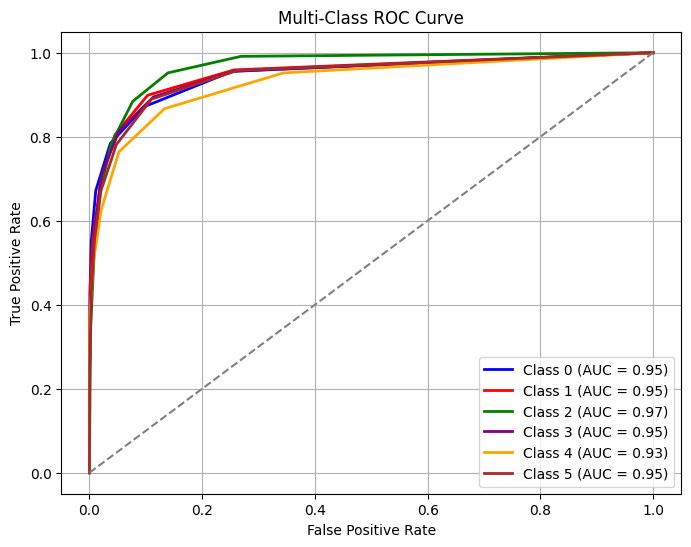

[0]	validation_0-mlogloss:1.51324
[1]	validation_0-mlogloss:1.33990
[2]	validation_0-mlogloss:1.21456
[3]	validation_0-mlogloss:1.12048
[4]	validation_0-mlogloss:1.04110
[5]	validation_0-mlogloss:0.97850
[6]	validation_0-mlogloss:0.92533
[7]	validation_0-mlogloss:0.87991
[8]	validation_0-mlogloss:0.83954
[9]	validation_0-mlogloss:0.80595
[10]	validation_0-mlogloss:0.77595
[11]	validation_0-mlogloss:0.75072
[12]	validation_0-mlogloss:0.72790
[13]	validation_0-mlogloss:0.70763
[14]	validation_0-mlogloss:0.68823
[15]	validation_0-mlogloss:0.67156
[16]	validation_0-mlogloss:0.65509
[17]	validation_0-mlogloss:0.64132
[18]	validation_0-mlogloss:0.62907
[19]	validation_0-mlogloss:0.61638
[20]	validation_0-mlogloss:0.60486
[21]	validation_0-mlogloss:0.59540
[22]	validation_0-mlogloss:0.58420
[23]	validation_0-mlogloss:0.57529
[24]	validation_0-mlogloss:0.56692
[25]	validation_0-mlogloss:0.55857
[26]	validation_0-mlogloss:0.55210
[27]	validation_0-mlogloss:0.54387
[28]	validation_0-mlogloss:0.5

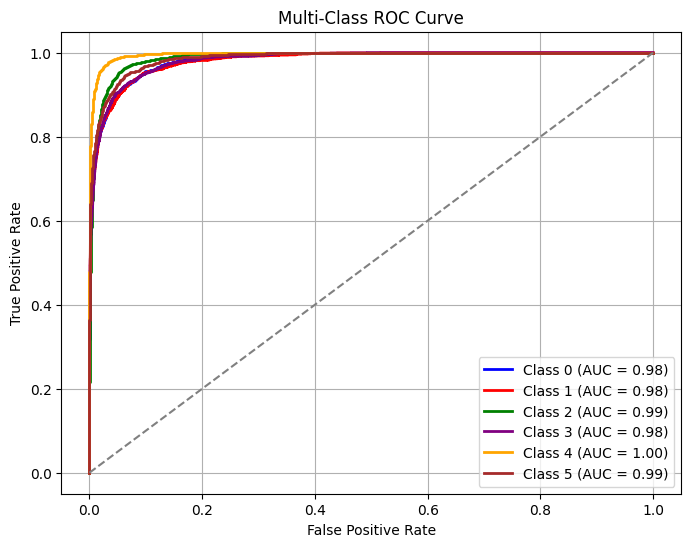

Epoch 1/20
3664/3664 [==============================] - 21s 5ms/step - loss: 1.1593 - accuracy: 0.5536 - val_loss: 0.7705 - val_accuracy: 0.7189
Epoch 2/20
3664/3664 [==============================] - 18s 5ms/step - loss: 0.8438 - accuracy: 0.6804 - val_loss: 0.6543 - val_accuracy: 0.7503
Epoch 3/20
3664/3664 [==============================] - 21s 6ms/step - loss: 0.7648 - accuracy: 0.7071 - val_loss: 0.5896 - val_accuracy: 0.7839
Epoch 4/20
3664/3664 [==============================] - 21s 6ms/step - loss: 0.7168 - accuracy: 0.7256 - val_loss: 0.5451 - val_accuracy: 0.7980
Epoch 5/20
3664/3664 [==============================] - 22s 6ms/step - loss: 0.6890 - accuracy: 0.7339 - val_loss: 0.5235 - val_accuracy: 0.8066
Epoch 6/20
3664/3664 [==============================] - 20s 6ms/step - loss: 0.6618 - accuracy: 0.7440 - val_loss: 0.5000 - val_accuracy: 0.8141
Epoch 7/20
3664/3664 [==============================] - 23s 6ms/step - loss: 0.6364 - accuracy: 0.7546 - val_loss: 0.4741 - val_ac

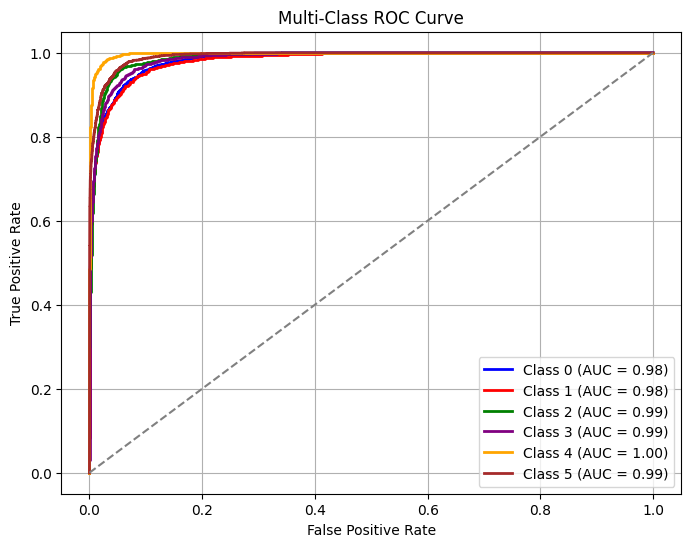

Explained variance by each component: [4.12695252e-01 1.31016463e-01 7.58680461e-02 5.22473099e-02
 4.95980555e-02 4.22130103e-02 3.68665553e-02 3.05098272e-02
 2.57495740e-02 2.14924434e-02 1.46641431e-02 1.40933485e-02
 1.28540104e-02 1.23223739e-02 8.55708916e-03 7.73200496e-03
 4.55538357e-03 4.05715325e-03 3.74904957e-03 3.44580862e-03
 3.03131777e-03 2.67892540e-03 2.50835083e-03 2.44387791e-03
 2.27082103e-03 1.88490303e-03 1.81075945e-03 1.62074460e-03
 1.47883476e-03 1.40279262e-03 1.24749971e-03 1.06389901e-03
 8.12033894e-04 8.01948032e-04 7.67312605e-04 7.07568486e-04
 6.65087458e-04 5.92372222e-04 5.78994076e-04 5.32429686e-04
 5.02079394e-04 4.48379303e-04 3.98512299e-04 3.72158648e-04
 3.43497696e-04 2.96319156e-04 2.90705443e-04 2.85299116e-04
 2.66605732e-04 2.28432764e-04 2.18255131e-04 2.13790080e-04
 2.06837398e-04 2.00392570e-04 1.86204111e-04 1.77575548e-04
 1.61384073e-04 1.52932205e-04 1.40782048e-04 1.37909704e-04
 1.21378640e-04 1.15490518e-04 1.11414051e-04 1

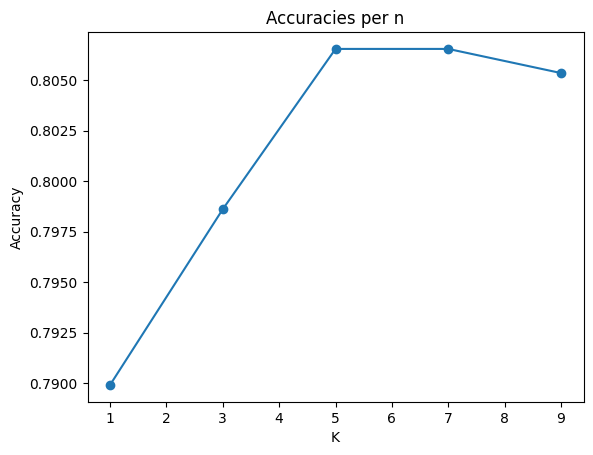

[[0.  0.  0.  1.  0.  0. ]
 [0.  0.2 0.  0.  0.8 0. ]
 [0.  0.  0.  0.  0.  1. ]
 ...
 [0.  0.  0.  0.  1.  0. ]
 [0.  1.  0.  0.  0.  0. ]
 [0.8 0.  0.  0.2 0.  0. ]]
              precision    recall  f1-score   support

           0       0.70      0.85      0.77      2426
           1       0.88      0.76      0.82      1992
           2       0.91      0.82      0.86       499
           3       0.82      0.72      0.77      1934
           4       0.82      0.79      0.80      2456
           5       0.84      0.88      0.86      2417

    accuracy                           0.81     11724
   macro avg       0.83      0.80      0.81     11724
weighted avg       0.81      0.81      0.81     11724

KNN model accuracy score: 0.8066
(11724, 6)
Evaluating KNN:
(11724, 6)


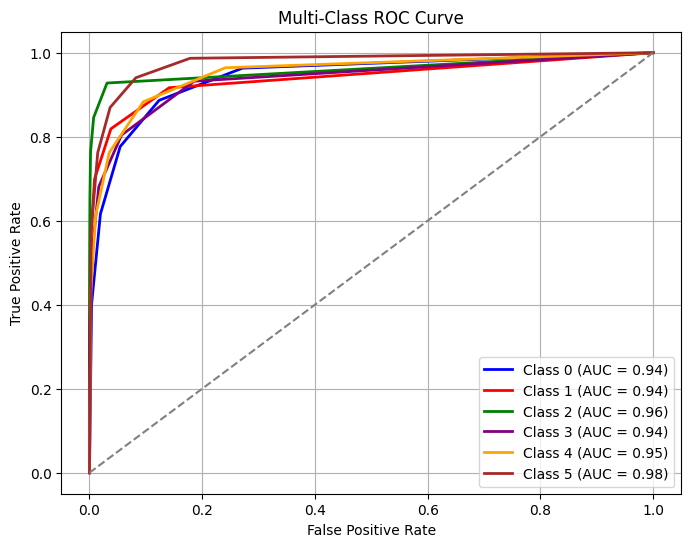

[0]	validation_0-mlogloss:1.46609
[1]	validation_0-mlogloss:1.28065
[2]	validation_0-mlogloss:1.15527
[3]	validation_0-mlogloss:1.05882
[4]	validation_0-mlogloss:0.97953
[5]	validation_0-mlogloss:0.91903
[6]	validation_0-mlogloss:0.86599
[7]	validation_0-mlogloss:0.82228
[8]	validation_0-mlogloss:0.78510
[9]	validation_0-mlogloss:0.75101
[10]	validation_0-mlogloss:0.72295
[11]	validation_0-mlogloss:0.69858
[12]	validation_0-mlogloss:0.67597
[13]	validation_0-mlogloss:0.65522
[14]	validation_0-mlogloss:0.63697
[15]	validation_0-mlogloss:0.61988
[16]	validation_0-mlogloss:0.60647
[17]	validation_0-mlogloss:0.59286
[18]	validation_0-mlogloss:0.58086
[19]	validation_0-mlogloss:0.57018
[20]	validation_0-mlogloss:0.55902
[21]	validation_0-mlogloss:0.54736
[22]	validation_0-mlogloss:0.53795
[23]	validation_0-mlogloss:0.52919
[24]	validation_0-mlogloss:0.52059
[25]	validation_0-mlogloss:0.51299
[26]	validation_0-mlogloss:0.50600
[27]	validation_0-mlogloss:0.50008
[28]	validation_0-mlogloss:0.4

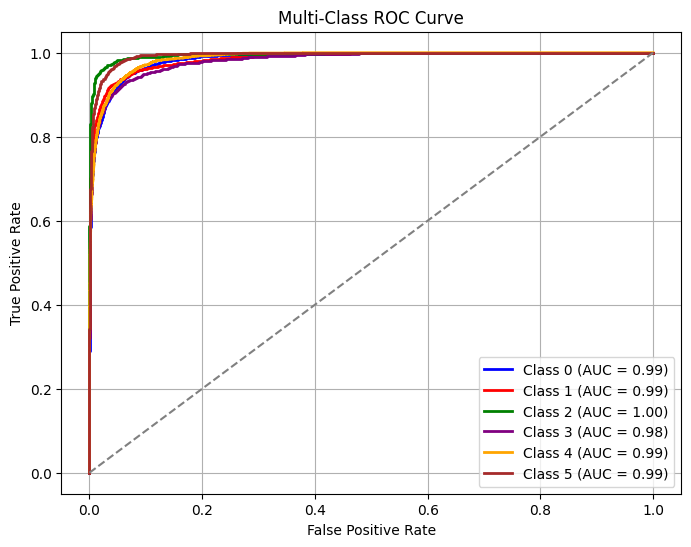

Epoch 1/20
3518/3518 [==============================] - 20s 5ms/step - loss: 1.1941 - accuracy: 0.5414 - val_loss: 0.9071 - val_accuracy: 0.6818
Epoch 2/20
3518/3518 [==============================] - 17s 5ms/step - loss: 0.9500 - accuracy: 0.6521 - val_loss: 0.7841 - val_accuracy: 0.7301
Epoch 3/20
3518/3518 [==============================] - 20s 6ms/step - loss: 0.8687 - accuracy: 0.6855 - val_loss: 0.7109 - val_accuracy: 0.7549
Epoch 4/20
3518/3518 [==============================] - 23s 7ms/step - loss: 0.8180 - accuracy: 0.7017 - val_loss: 0.6647 - val_accuracy: 0.7711
Epoch 5/20
3518/3518 [==============================] - 19s 5ms/step - loss: 0.7720 - accuracy: 0.7232 - val_loss: 0.6279 - val_accuracy: 0.7839
Epoch 6/20
3518/3518 [==============================] - 18s 5ms/step - loss: 0.7551 - accuracy: 0.7290 - val_loss: 0.6038 - val_accuracy: 0.7973
Epoch 7/20
3518/3518 [==============================] - 18s 5ms/step - loss: 0.7313 - accuracy: 0.7352 - val_loss: 0.5948 - val_ac

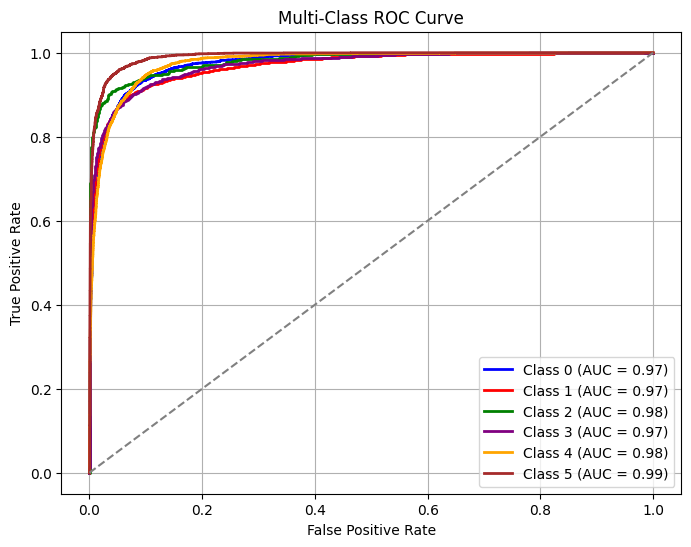

Explained variance by each component: [3.86144577e-01 1.64866044e-01 7.26441852e-02 4.96131675e-02
 4.59186136e-02 3.83573999e-02 3.01376808e-02 2.86044215e-02
 2.61795932e-02 2.28884636e-02 2.02951450e-02 1.48340102e-02
 1.33988323e-02 1.17876051e-02 9.52760431e-03 7.49145540e-03
 5.44131486e-03 5.03840813e-03 4.67013459e-03 3.46909506e-03
 3.42320410e-03 3.00000116e-03 2.50975720e-03 1.98937537e-03
 1.89863389e-03 1.84361920e-03 1.75381621e-03 1.65472292e-03
 1.43551773e-03 1.33076693e-03 1.25390293e-03 1.19226220e-03
 1.11654695e-03 1.03463640e-03 9.37278813e-04 8.70722957e-04
 8.29213670e-04 7.27537833e-04 6.71582225e-04 6.67244725e-04
 6.28832775e-04 5.76040301e-04 5.06834826e-04 4.47492518e-04
 4.28296523e-04 4.02357422e-04 3.76395098e-04 3.48408439e-04
 3.31374632e-04 3.17304341e-04 2.83767295e-04 2.75433883e-04
 2.44220821e-04 2.39165315e-04 2.24182184e-04 2.16680748e-04
 1.99613283e-04 1.96096414e-04 1.76115304e-04 1.65888571e-04
 1.59813419e-04 1.41661444e-04 1.39510737e-04 1

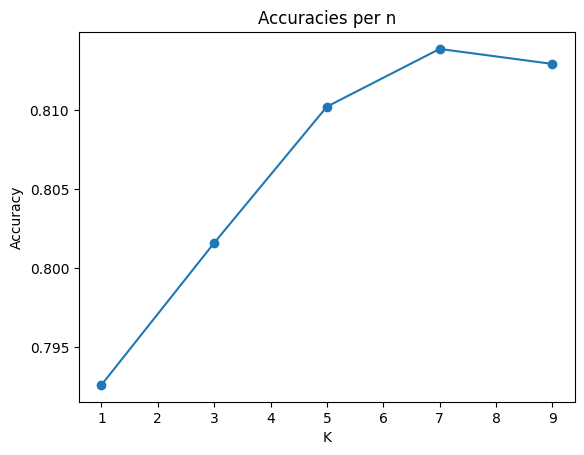

[[0.         0.         0.14285714 0.         0.85714286 0.        ]
 [0.         0.         0.         0.14285714 0.         0.85714286]
 [0.         0.         1.         0.         0.         0.        ]
 ...
 [0.42857143 0.         0.42857143 0.         0.         0.14285714]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]]
              precision    recall  f1-score   support

           0       0.67      0.71      0.69      1945
           1       0.80      0.93      0.86      2513
           2       0.76      0.83      0.79      2438
           3       0.89      0.80      0.85      2479
           4       0.87      0.82      0.84      2378
           5       0.93      0.75      0.83      1925

    accuracy                           0.81     13678
   macro avg       0.82      0.81      0.81     13678
weighted avg       0.82      0.81      0.81     13678

KNN model accuracy score: 0.8139
(136

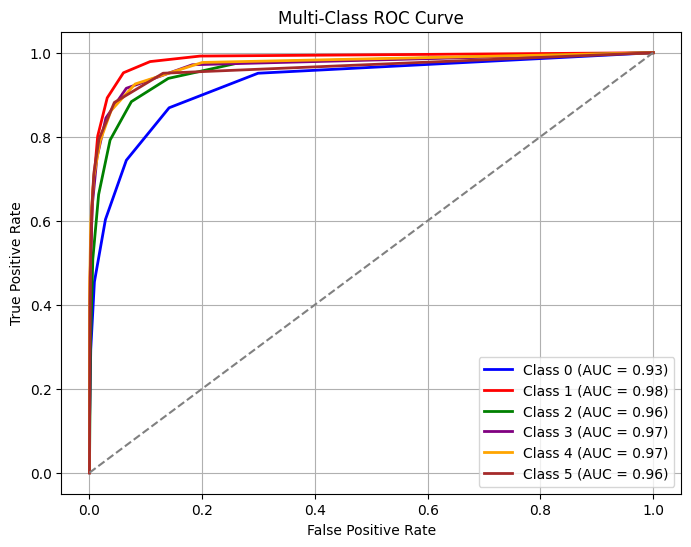

[0]	validation_0-mlogloss:1.45808
[1]	validation_0-mlogloss:1.26931
[2]	validation_0-mlogloss:1.13699
[3]	validation_0-mlogloss:1.03216
[4]	validation_0-mlogloss:0.94855
[5]	validation_0-mlogloss:0.88204
[6]	validation_0-mlogloss:0.82470
[7]	validation_0-mlogloss:0.78075
[8]	validation_0-mlogloss:0.73967
[9]	validation_0-mlogloss:0.70810
[10]	validation_0-mlogloss:0.67681
[11]	validation_0-mlogloss:0.65254
[12]	validation_0-mlogloss:0.62867
[13]	validation_0-mlogloss:0.60749
[14]	validation_0-mlogloss:0.58925
[15]	validation_0-mlogloss:0.57247
[16]	validation_0-mlogloss:0.55734
[17]	validation_0-mlogloss:0.54095
[18]	validation_0-mlogloss:0.52615
[19]	validation_0-mlogloss:0.51442
[20]	validation_0-mlogloss:0.50214
[21]	validation_0-mlogloss:0.49104
[22]	validation_0-mlogloss:0.48233
[23]	validation_0-mlogloss:0.47122
[24]	validation_0-mlogloss:0.46191
[25]	validation_0-mlogloss:0.45334
[26]	validation_0-mlogloss:0.44612
[27]	validation_0-mlogloss:0.43843
[28]	validation_0-mlogloss:0.4

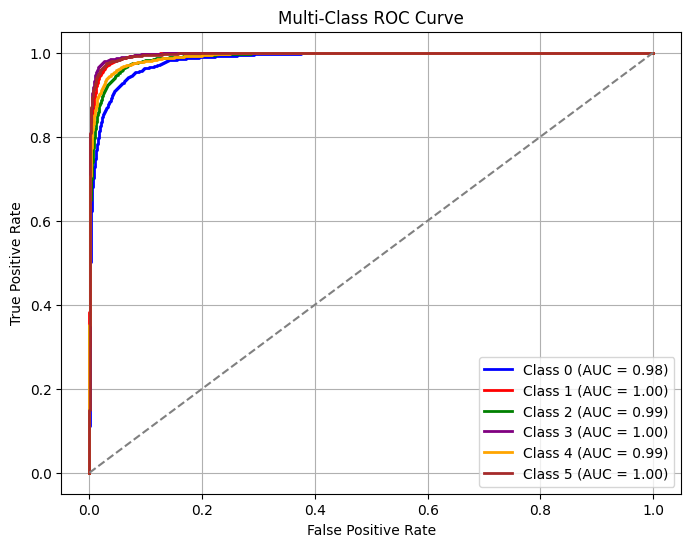

Epoch 1/20
4104/4104 [==============================] - 29s 7ms/step - loss: 1.0902 - accuracy: 0.5886 - val_loss: 0.7598 - val_accuracy: 0.7225
Epoch 2/20
4104/4104 [==============================] - 26s 6ms/step - loss: 0.8269 - accuracy: 0.6915 - val_loss: 0.6451 - val_accuracy: 0.7601
Epoch 3/20
4104/4104 [==============================] - 26s 6ms/step - loss: 0.7521 - accuracy: 0.7182 - val_loss: 0.5785 - val_accuracy: 0.7867
Epoch 4/20
4104/4104 [==============================] - 22s 5ms/step - loss: 0.6978 - accuracy: 0.7370 - val_loss: 0.5354 - val_accuracy: 0.8076
Epoch 5/20
4104/4104 [==============================] - 22s 5ms/step - loss: 0.6600 - accuracy: 0.7530 - val_loss: 0.5068 - val_accuracy: 0.8150
Epoch 6/20
4104/4104 [==============================] - 21s 5ms/step - loss: 0.6323 - accuracy: 0.7623 - val_loss: 0.4814 - val_accuracy: 0.8253
Epoch 7/20
4104/4104 [==============================] - 20s 5ms/step - loss: 0.6141 - accuracy: 0.7696 - val_loss: 0.4603 - val_ac

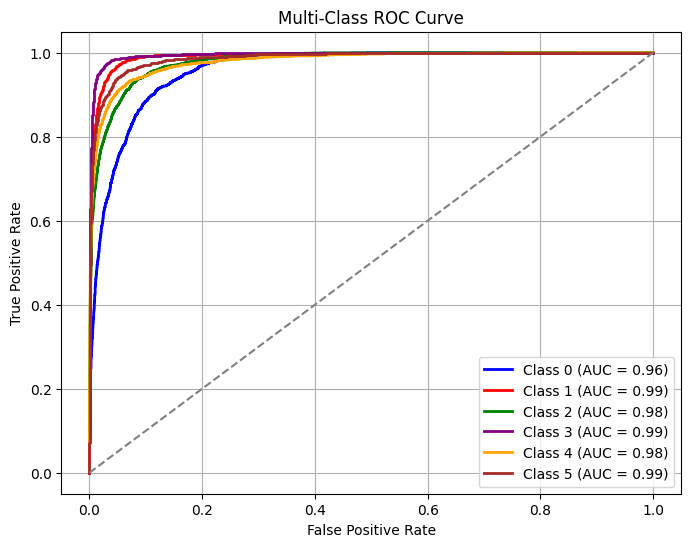

In [42]:
Unique_IDs = df.iloc[:, -1].unique()

for i in range(3):
    # Sample 6 unique IDs
    Unique_IDs_sample = np.random.choice(Unique_IDs, size=6, replace=False)
    df_sample = df[df.iloc[:, -1].isin(Unique_IDs_sample)]

    # Reassign labels to range(6)
    df_sample.iloc[:, -1] = df_sample.iloc[:, -1].replace(Unique_IDs_sample, list(range(6)))
    df_sample = df_sample.values

    # Split features and labels
    X_train, X_test, y_train, y_test = train_test_split(df_sample[:, :-2], df_sample[:, -1], test_size=0.25, random_state=0)

    # Scale features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA
    n_components = 70  # Adjust based on explained variance preference
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Explained variance ratio
    explained_variance = pca.explained_variance_ratio_
    print("Explained variance by each component:", explained_variance)
    print("Total explained variance:", np.sum(explained_variance))

    # Convert labels to integers
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)

    print("Type of y_train:", type_of_target(y_train))
    print("y_train shape:", y_train.shape)
    print("Unique values in y_train:", set(y_train))


    # Model Training & Evaluation
    for model_name, model_function in [("KNN", Knn), ("XGBoost", XG_Boost),("MLP", Mlp_2)]:
        y_pred_proba = model_function(X_train_pca, X_test_pca, y_train, y_test)  # Ensure this returns probabilities
        print(y_pred_proba.shape)
        print(f"Evaluating {model_name}:")
        ROC_curve_multi(y_test, y_pred_proba, 6)

In [6]:
df_female = df[df.iloc[:, -2] == 'female'].sample(10000).values
df_male = df[df.iloc[:, -2] == 'male'].sample(10000).values

dataset = np.concatenate((df_female, df_male), axis=0)
X = dataset[:, :-2]
y = dataset[:, -2]
y = np.array([1 if gender == "male" else 0 for gender in y])


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

scaler = MinMaxScaler()

X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Apply PCA
from sklearn.decomposition import PCA

n_components = 70 # Adjust based on explained variance preference
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained variance by each component:", explained_variance)
print("Total explained variance:", np.sum(explained_variance))


Explained variance by each component: [3.40079693e-01 1.42828359e-01 7.60744368e-02 5.76543525e-02
 5.03372303e-02 4.49147538e-02 3.59871217e-02 3.42664751e-02
 3.03854367e-02 2.92511696e-02 1.92726546e-02 1.66327648e-02
 1.36203442e-02 1.22441524e-02 1.02714416e-02 8.44839490e-03
 7.81576473e-03 7.09090065e-03 5.79853949e-03 4.67170080e-03
 3.84501093e-03 3.53597536e-03 3.41688021e-03 3.17256915e-03
 2.97457256e-03 2.75152508e-03 2.72820866e-03 2.34012369e-03
 2.08693671e-03 1.79559915e-03 1.74744442e-03 1.69584767e-03
 1.63477481e-03 1.50270180e-03 1.23490095e-03 1.10357861e-03
 1.00458046e-03 9.35732088e-04 8.84564195e-04 8.45719751e-04
 8.25052333e-04 7.20406005e-04 6.64656062e-04 6.33538077e-04
 5.76602913e-04 5.41230793e-04 5.10060557e-04 4.89589998e-04
 4.71350251e-04 4.23210483e-04 3.83637607e-04 3.68842501e-04
 3.47908875e-04 3.16723186e-04 2.98693660e-04 2.82526942e-04
 2.67841617e-04 2.47872890e-04 2.35544977e-04 2.34207767e-04
 2.21726561e-04 1.98572152e-04 1.84551173e-04 1

Explained variance by each component: [0.27520678 0.16180783]
Total explained variance: 0.4370146060602334


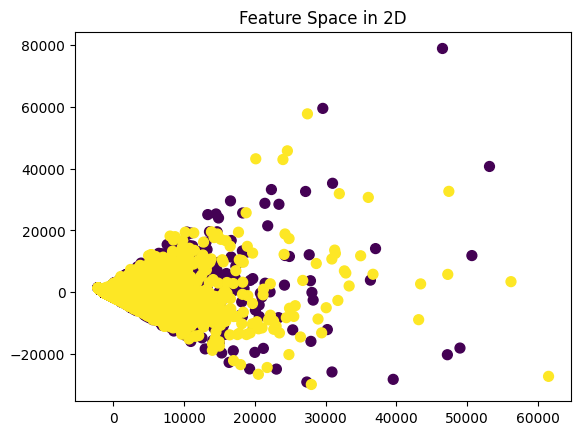

In [50]:
# Apply PCA
from sklearn.decomposition import PCA

pca2 = PCA(n_components=2)
X_pca = pca2.fit_transform(X)


explained_variance1 = pca2.explained_variance_ratio_
print("Explained variance by each component:", explained_variance1)
print("Total explained variance:", np.sum(explained_variance1))

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1],c= y, s=50, cmap='viridis')
plt.title("Feature Space in 2D")
plt.show()



In [10]:
def logistic_regression(X_train_scaled, X_test_scaled, y_train, y_test):
    logisticRegr = LogisticRegression(max_iter = 2000)

    logisticRegr.fit(X_train_scaled, y_train)

    logisticRegr.predict(X_test_scaled[0].reshape(1,-1))

    y_pred = logisticRegr.predict(X_test_scaled)
    
    print(classification_report(y_test, y_pred))
    

    print('Logistic Regression model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
    return y_pred

              precision    recall  f1-score   support

           0       0.76      0.73      0.74      2477
           1       0.74      0.78      0.76      2523

    accuracy                           0.75      5000
   macro avg       0.75      0.75      0.75      5000
weighted avg       0.75      0.75      0.75      5000

Logistic Regression model accuracy score: 0.7522


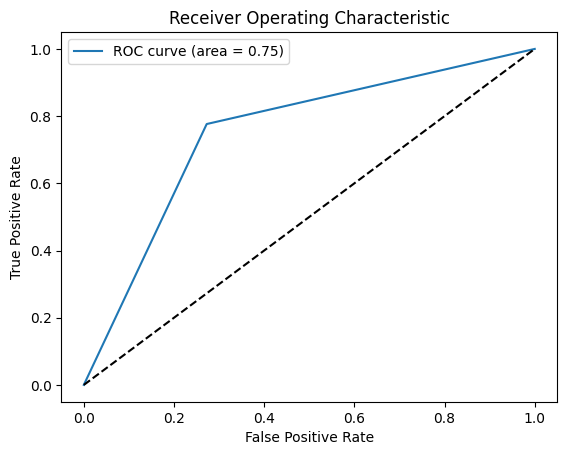

<Axes: >

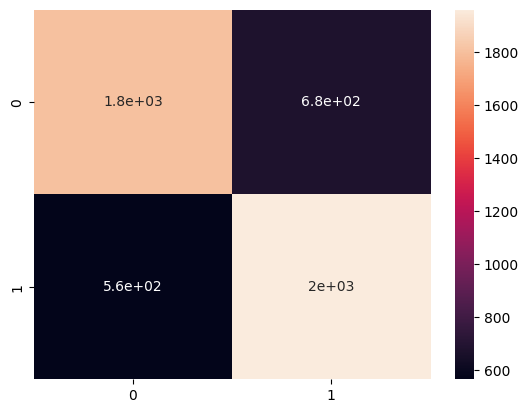

In [11]:
y_pred = logistic_regression(X_train_pca, X_test_pca, y_train, y_test)
ROC_curve(y_test, y_pred)
sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)

In [21]:
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import type_of_target

def Knn(X_train, X_test, y_train, y_test):
    accuracies = []

    for k in range(1, 11, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)

        y_pred = knn.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))

    plt.plot(range(1, 10, 2), accuracies, marker='o')
    plt.title("Accuracies per n")
    plt.xlabel("K")
    plt.ylabel("Accuracy")
    plt.show()

    KNN = KNeighborsClassifier(n_neighbors = np.argmax(accuracies)*2+1)
    KNN.fit(X_train, y_train)

    y_pred = KNN.predict(X_test)

    print(KNN.predict_proba(X_test))

    print(classification_report(y_test, y_pred))

    y_proba = KNN.predict_proba(X_test)

    print('KNN model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
    return y_proba

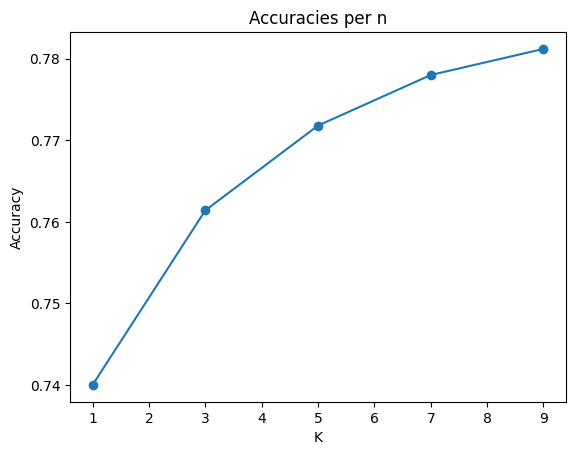

[[0.11111111 0.88888889]
 [0.55555556 0.44444444]
 [0.44444444 0.55555556]
 ...
 [0.44444444 0.55555556]
 [0.55555556 0.44444444]
 [0.11111111 0.88888889]]
              precision    recall  f1-score   support

           0       0.79      0.75      0.77      2477
           1       0.77      0.81      0.79      2523

    accuracy                           0.78      5000
   macro avg       0.78      0.78      0.78      5000
weighted avg       0.78      0.78      0.78      5000

KNN model accuracy score: 0.7812


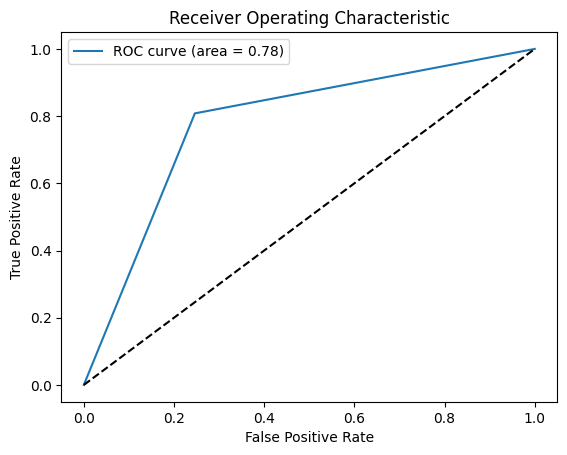

<Axes: >

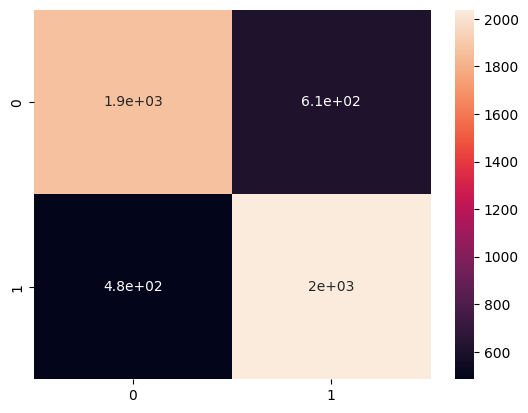

In [33]:
y_pred = Knn(X_train_pca, X_test_pca, y_train, y_test)
ROC_curve(y_test,y_pred)
sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)

In [25]:
def XG_Boost(X_train, X_test, y_train, y_test):
    clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
    # Fit the model, test sets are used for early stopping.
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    # Save model into JSON format.

    y_pred = clf.predict(X_test)

    print(classification_report(y_test, y_pred))

    y_proba = clf.predict_proba(X_test)


    print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
    return y_proba

[0]	validation_0-logloss:0.62611
[1]	validation_0-logloss:0.58642
[2]	validation_0-logloss:0.55973
[3]	validation_0-logloss:0.53893
[4]	validation_0-logloss:0.52629
[5]	validation_0-logloss:0.51582
[6]	validation_0-logloss:0.50767
[7]	validation_0-logloss:0.49918
[8]	validation_0-logloss:0.49422
[9]	validation_0-logloss:0.48831
[10]	validation_0-logloss:0.48095
[11]	validation_0-logloss:0.47534
[12]	validation_0-logloss:0.47203
[13]	validation_0-logloss:0.47066
[14]	validation_0-logloss:0.46705
[15]	validation_0-logloss:0.46349
[16]	validation_0-logloss:0.45918
[17]	validation_0-logloss:0.45855
[18]	validation_0-logloss:0.45739
[19]	validation_0-logloss:0.45640
[20]	validation_0-logloss:0.45474
[21]	validation_0-logloss:0.45273
[22]	validation_0-logloss:0.44997
[23]	validation_0-logloss:0.44879
[24]	validation_0-logloss:0.44554
[25]	validation_0-logloss:0.44376
[26]	validation_0-logloss:0.44257
[27]	validation_0-logloss:0.44221
[28]	validation_0-logloss:0.44159
[29]	validation_0-loglos

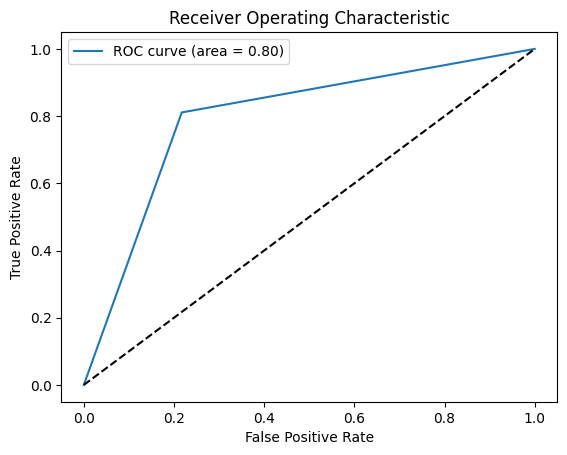

<Axes: >

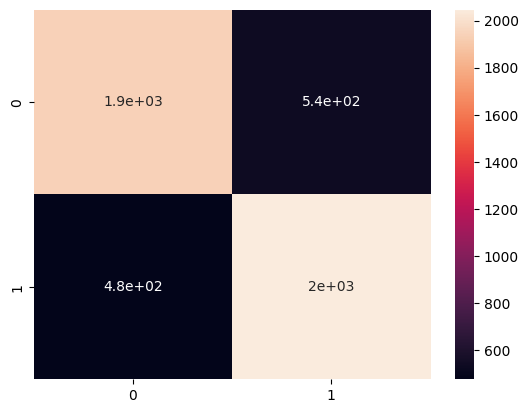

In [34]:
y_pred = XG_Boost(X_train_pca, X_test_pca, y_train, y_test)
ROC_curve(y_test,y_pred)
sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)

In [37]:
def Mlp(X_train, X_test, y_train, y_test):
    def create_mlp(input_dim):
        model = Sequential([
            Dense(16, activation='relu', input_shape=(input_dim,)),  # Hidden Layer 1
            Dense(8, activation='relu'),  # Hidden Layer 2
            Dense(1, activation='sigmoid')  # Output Layer (Sigmoid for probabilities)
        ])
        
        # Compile the model
        model.compile(optimizer=Adam(learning_rate=0.001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
        
        return model

    # Example: Create model with 151 features
    input_dim = 70
    mlp_model = create_mlp(input_dim)

    # Train the model
    history = mlp_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

    # Make predictions (convert probabilities to 0 or 1)
    y_pred = (mlp_model.predict(X_test) >= 0.5).astype(int)
    
    print(classification_report(y_test, y_pred))

    print('MLP model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

    return y_pred

Epoch 1/50
938/938 [==============================] - 3s 3ms/step - loss: 0.5660 - accuracy: 0.7163 - val_loss: 0.5134 - val_accuracy: 0.7534
Epoch 2/50
938/938 [==============================] - 2s 2ms/step - loss: 0.4932 - accuracy: 0.7517 - val_loss: 0.5217 - val_accuracy: 0.7550
Epoch 3/50
938/938 [==============================] - 2s 2ms/step - loss: 0.4803 - accuracy: 0.7616 - val_loss: 0.5264 - val_accuracy: 0.7642
Epoch 4/50
938/938 [==============================] - 2s 2ms/step - loss: 0.4697 - accuracy: 0.7691 - val_loss: 0.5270 - val_accuracy: 0.7704
Epoch 5/50
938/938 [==============================] - 2s 2ms/step - loss: 0.4605 - accuracy: 0.7725 - val_loss: 0.5244 - val_accuracy: 0.7776
Epoch 6/50
938/938 [==============================] - 2s 2ms/step - loss: 0.4520 - accuracy: 0.7785 - val_loss: 0.5247 - val_accuracy: 0.7778
Epoch 7/50
938/938 [==============================] - 2s 2ms/step - loss: 0.4444 - accuracy: 0.7815 - val_loss: 0.5290 - val_accuracy: 0.7784
Epoch 

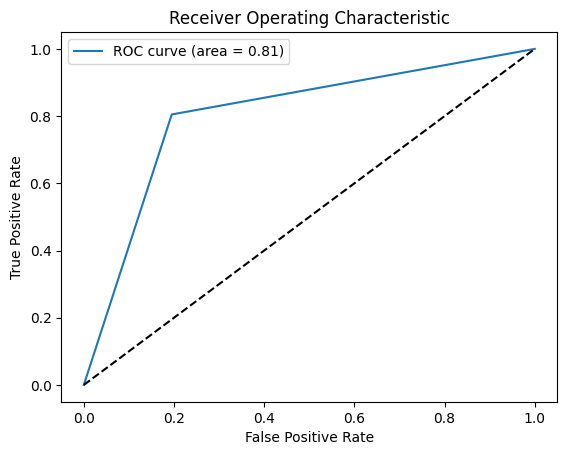

<Axes: >

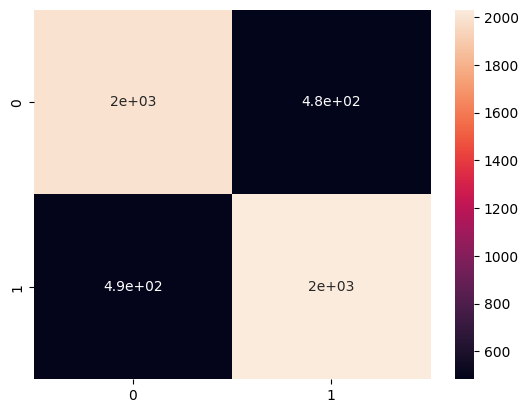

In [39]:
y_pred = Mlp(X_train_pca, X_test_pca, y_train, y_test)
ROC_curve(y_test, y_pred)
sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)

### MLP

In [41]:
def Mlp_2(X_train, X_test, y_train, y_test):
    def create_mlp(input_dim):
        model = Sequential([
            Dense(32, activation='relu', input_shape=(input_dim,)),  # Hidden Layer 1
            Dropout(0.2),
            Dense(16, activation='relu'),  # Hidden Layer 2
            Dropout(0.2),
            Dense(6, activation='softmax')  # Output Layer (Sigmoid for probabilities)
        ])
        
        # Compile the model
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        
        return model

    # Example: Create model with 151 features
    input_dim =70
    mlp_model = create_mlp(input_dim)

    # Train the model
    history = mlp_model.fit(X_train, y_train, epochs=20, batch_size=10, validation_data=(X_test, y_test), verbose=1)
    
    loss, accuracy = mlp_model.evaluate(tf.convert_to_tensor(X_test, dtype=tf.float32),tf.convert_to_tensor(y_test, dtype=tf.int32))
    
    y_proba = mlp_model.predict(X_test)
    y_pred = np.argmax(y_proba, axis=1)

    print(classification_report(y_test, y_pred))

    print(f'Test Accuracy: {accuracy:.4f}')
    return y_proba

### Clustering

In [31]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.cluster import KMeans
                

In [32]:

df_female = df[df.iloc[:, -2] == 'female'].sample(10000).values
df_male = df[df.iloc[:, -2] == 'male'].sample(10000).values

dataset = np.concatenate((df_female, df_male), axis = 0)
dataset[:,-2] =np.array([1 if gender == "male" else 0 for gender in dataset[:,-2]])


In [33]:
def silhouette(df):
    range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
    silhouette_avg = []
    for num_clusters in range_n_clusters:
 
    # initialise kmeans
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(df)
        cluster_labels = kmeans.labels_
 
        silhouette_avg.append(silhouette_score(df, cluster_labels, metric="cosine"))
    plt.plot(range_n_clusters,silhouette_avg,'bx-')
    plt.xlabel("Values of K") 
    plt.ylabel("Silhouette score") 
    plt.title("Silhouette analysis For Optimal k")
    plt.show()

    return

In [73]:
def elbow_method(df):
    Sum_of_squared_distances = []
    K = range(1,10,2)
    for num_clusters in K :
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(df)
        Sum_of_squared_distances.append(kmeans.inertia_)
    plt.plot(K,Sum_of_squared_distances,'bx-')
    plt.xlabel("Values of K") 
    plt.ylabel("Sum of squared distances/Inertia") 
    plt.title("Elbow Method For Optimal")
    plt.show()
    return

In [34]:
scaler = MinMaxScaler()

dataset_scaled = scaler.fit_transform(dataset[:])


In [75]:
dataset_scaled.shape


(20000, 153)

In [35]:
# Apply PCA
from sklearn.decomposition import PCA

n_components = 14 # Adjust based on explained variance preference
pca = PCA(n_components=n_components)
dataset_pca = pca.fit_transform(dataset_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained variance by each component:", explained_variance)
print("Total explained variance:", np.sum(explained_variance))


Explained variance by each component: [0.35927998 0.21854259 0.08679668 0.04696586 0.03406842 0.03008297
 0.02928788 0.02414719 0.02329567 0.02155286 0.01939615 0.01677618
 0.01179877 0.01049039]
Total explained variance: 0.9324815864731087


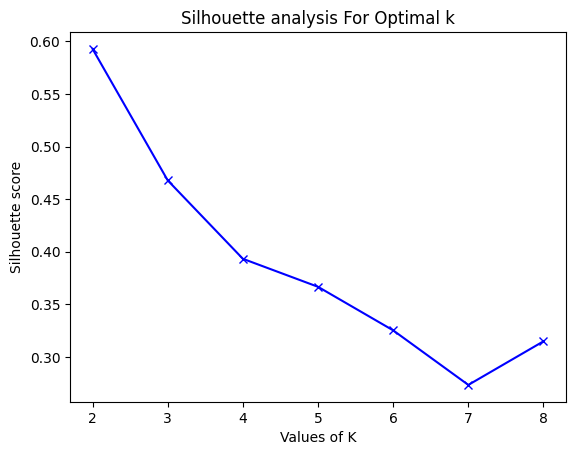

In [77]:
silhouette(dataset_pca)

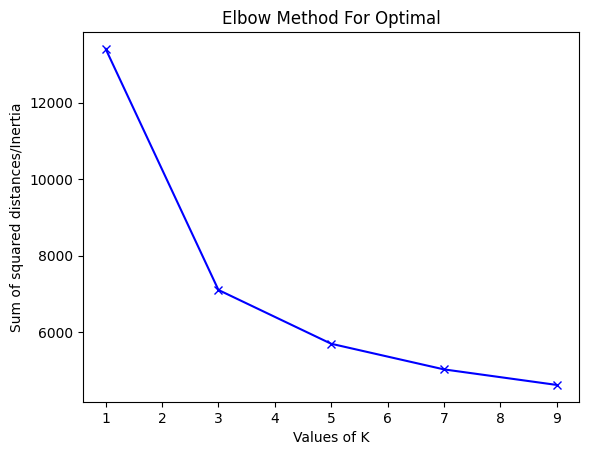

In [79]:
elbow_method(dataset_pca)

In [82]:
kmeans = KMeans(n_clusters = 7, random_state = 101, n_init = "auto").fit(dataset_pca)

In [84]:
print(kmeans.labels_.shape)

(20000,)


silhouette_score is  0.3246240771460198 for eps =  0.5
The number of cluster and their count's of them for eps = 0.5 is Counter({0: 9992, 1: 9724, 2: 248, -1: 23, 3: 8, 4: 5})


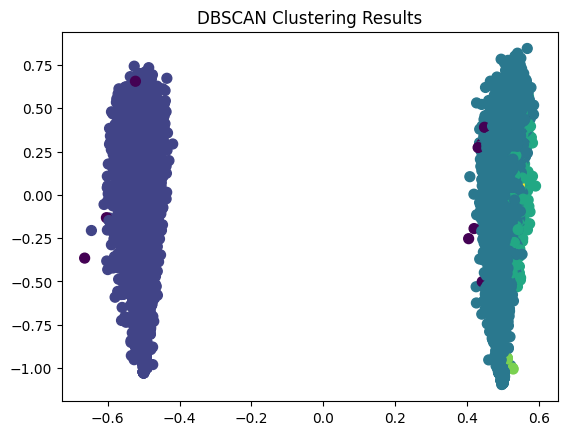

silhouette_score is  0.33219272809950096 for eps =  0.6
The number of cluster and their count's of them for eps = 0.6 is Counter({0: 9999, 1: 9736, 2: 254, 3: 8, -1: 3})


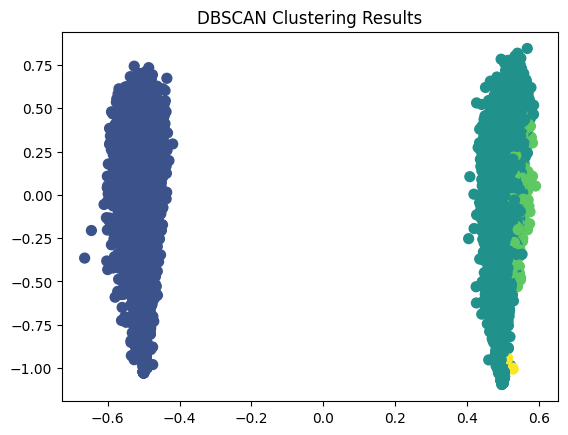

silhouette_score is  0.36038654066941644 for eps =  0.7
The number of cluster and their count's of them for eps = 0.7 is Counter({0: 10000, 1: 9999, -1: 1})


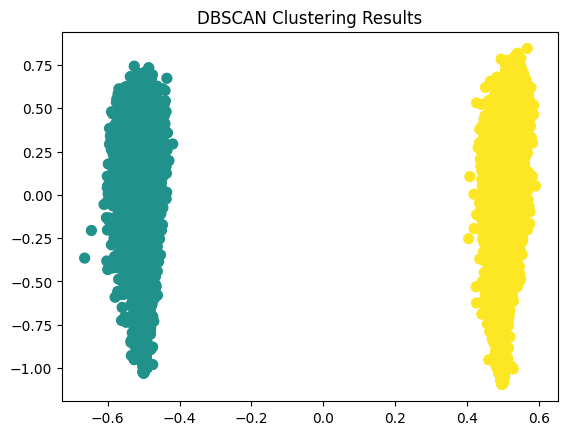

silhouette_score is  0.3639394683203032 for eps =  0.8
The number of cluster and their count's of them for eps = 0.8 is Counter({0: 10000, 1: 10000})


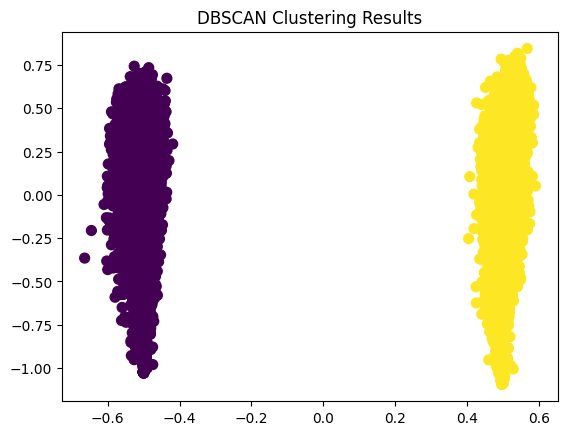

silhouette_score is  0.3639394683203032 for eps =  0.9
The number of cluster and their count's of them for eps = 0.9 is Counter({0: 10000, 1: 10000})


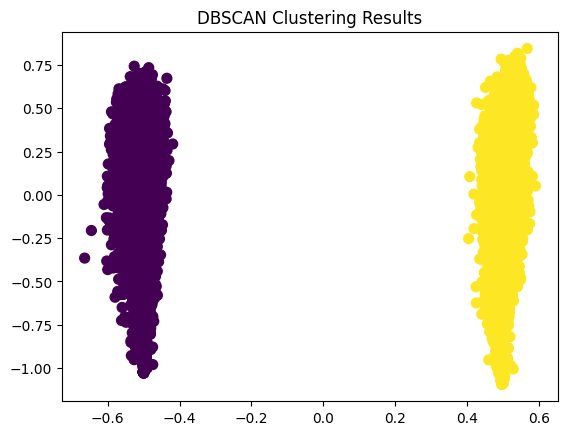

In [43]:
from collections import Counter
from sklearn.cluster import DBSCAN
for eps in [0.5,0.6,0.7,0.8,0.9]:
    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=5)
    y_dbscan = dbscan.fit_predict(dataset_pca)

    print("silhouette_score is ", silhouette_score(dataset_pca,y_dbscan), "for eps = ", eps)
    
    print("The number of cluster and their count's of them for eps =",eps, 'is', Counter(y_dbscan))
    # Visualize the result
    plt.figure()
    plt.scatter(dataset_pca[:, 0], dataset_pca[:, 1], c=y_dbscan, s=50, cmap='viridis')
    plt.title("DBSCAN Clustering Results")
    plt.show()

